In [1]:
# Cell 1: Imports & setup

import pandas as pd
import numpy as np

from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error
from sklearn.linear_model import LinearRegression, Ridge
from sklearn.ensemble import (
    RandomForestRegressor, GradientBoostingRegressor, ExtraTreesRegressor,
    HistGradientBoostingRegressor, StackingRegressor
)

import torch
import torch.nn as nn
from torch.utils.data import TensorDataset, DataLoader

import matplotlib.pyplot as plt
import seaborn as sns

import warnings
warnings.filterwarnings("ignore")

# Check for optional dependencies
try:
    from xgboost import XGBRegressor
    XGBOOST = True
except ImportError:
    XGBOOST = False
    print('XGBoost not installed — will use HistGradientBoosting as substitute')

try:
    from lightgbm import LGBMRegressor
    LIGHTGBM = True
except ImportError:
    LIGHTGBM = False
    print('LightGBM not installed')

try:
    from catboost import CatBoostRegressor
    CATBOOST = True
except ImportError:
    CATBOOST = False
    print('CatBoost not installed')

# Random state for reproducibility
RANDOM_STATE = 42
np.random.seed(RANDOM_STATE)

pd.set_option("display.max_columns", 50)
print('✅ All imports successful')


✅ All imports successful


In [2]:
# Cell 2: Load & quick inspect

df = pd.read_csv("Carbon-Emission.csv")  # your file[file:86]

print("Shape:", df.shape)
print("Columns:", df.columns.tolist())
print(df.head())
print("\nTarget stats (CarbonEmission):")
print(df["CarbonEmission"].describe())


Shape: (10000, 20)
Columns: ['Body Type', 'Sex', 'Diet', 'How Often Shower', 'Heating Energy Source', 'Transport', 'Vehicle Type', 'Social Activity', 'Monthly Grocery Bill', 'Frequency of Traveling by Air', 'Vehicle Monthly Distance Km', 'Waste Bag Size', 'Waste Bag Weekly Count', 'How Long TV PC Daily Hour', 'How Many New Clothes Monthly', 'How Long Internet Daily Hour', 'Energy efficiency', 'Recycling', 'Cooking_With', 'CarbonEmission']
    Body Type     Sex         Diet How Often Shower Heating Energy Source  \
0  overweight  female  pescatarian            daily                  coal   
1       obese  female   vegetarian  less frequently           natural gas   
2  overweight    male     omnivore  more frequently                  wood   
3  overweight    male     omnivore      twice a day                  wood   
4       obese  female   vegetarian            daily                  coal   

      Transport Vehicle Type Social Activity  Monthly Grocery Bill  \
0        public         

In [3]:
# Cell 3: Preprocess – encode categoricals + add physics feature

df_proc = df.copy()

# Auto-detect categorical columns (object dtype)
cat_cols = df_proc.select_dtypes(include=['object']).columns.tolist()

# Remove target if present
if 'CarbonEmission' in cat_cols:
    cat_cols.remove('CarbonEmission')

print(f"Encoding categorical columns: {cat_cols}")

encoders = {}
for col in cat_cols:
    if col in df_proc.columns:
        le = LabelEncoder()
        df_proc[col] = le.fit_transform(df_proc[col].astype(str))
        encoders[col] = le

# Physics-informed feature: Waste_Physics ~ size * count
# We convert 'Waste Bag Size' to a factor and multiply by weekly count
size_map = {
    "small": 1.0,
    "medium": 1.2,
    "large": 1.4,
    "extra large": 1.6
}

df_proc["Waste_Size_Factor"] = df["Waste Bag Size"].map(size_map).fillna(1.0)
df_proc["Waste_Physics"] = df_proc["Waste Bag Weekly Count"].fillna(0) * df_proc["Waste_Size_Factor"]

print("Physics feature correlation with CarbonEmission:")
print(np.corrcoef(df_proc["Waste_Physics"], df_proc["CarbonEmission"])[0, 1])

Encoding categorical columns: ['Body Type', 'Sex', 'Diet', 'How Often Shower', 'Heating Energy Source', 'Transport', 'Vehicle Type', 'Social Activity', 'Frequency of Traveling by Air', 'Waste Bag Size', 'Energy efficiency', 'Recycling', 'Cooking_With']
Physics feature correlation with CarbonEmission:
0.20496278141494487


In [4]:
# Cell 4: Train/test split + scaling

# Drop non-numeric / unused for tabular models
drop_cols = ["CarbonEmission", "Cooking_With"]  # Cooking_With is string-list
X = df_proc.drop(columns=[c for c in drop_cols if c in df_proc.columns])
y = df_proc["CarbonEmission"]

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

print("Train shape:", X_train.shape, "Test shape:", X_test.shape)


Train shape: (8000, 20) Test shape: (2000, 20)


In [5]:
# Cell 5: Define 5 candidate ML models

models = {
    "LinearRegression": LinearRegression(),
    "Ridge": Ridge(alpha=1.0),
    "RandomForest": RandomForestRegressor(
        n_estimators=200, random_state=42, n_jobs=-1
    ),
    "GradientBoosting": GradientBoostingRegressor(
        n_estimators=200, random_state=42
    ),
    "ExtraTrees": ExtraTreesRegressor(
        n_estimators=200, random_state=42, n_jobs=-1
    )
}


In [6]:
# ============================================================
# CELL 8: BENCHMARK ALL MODELS (EXTENDED SOTA VERSION)
# ============================================================

from lightgbm import LGBMRegressor
from catboost import CatBoostRegressor
from sklearn.ensemble import StackingRegressor
from sklearn.linear_model import Ridge

models = {
    # Linear models
    'Linear Regression': (
        LinearRegression(), True
    ),
    
    'Ridge Regression': (
        Ridge(alpha=1.0), True
    ),

    # Bagging models
    'Random Forest': (
        RandomForestRegressor(
            n_estimators=400,
            max_depth=14,
            random_state=RANDOM_STATE,
            n_jobs=-1
        ), False
    ),

    'Extra Trees': (
        ExtraTreesRegressor(
            n_estimators=400,
            max_depth=14,
            random_state=RANDOM_STATE,
            n_jobs=-1
        ), False
    ),

    # Boosting models
    'Gradient Boosting': (
        GradientBoostingRegressor(
            n_estimators=500,
            learning_rate=0.05,
            max_depth=6,
            subsample=0.85,
            random_state=RANDOM_STATE
        ), False
    ),

    # Tuned HistGBM (strong baseline)
    'Hist Gradient Boosting (Tuned)': (
        HistGradientBoostingRegressor(
            max_iter=800,
            learning_rate=0.03,
            max_depth=10,
            l2_regularization=0.1,
            random_state=RANDOM_STATE
        ), False
    ),

    # LightGBM (VERY STRONG)
    'LightGBM': (
        LGBMRegressor(
            n_estimators=1500,
            learning_rate=0.01,
            num_leaves=31,
            subsample=0.8,
            colsample_bytree=0.8,
            random_state=RANDOM_STATE,
            n_jobs=-1
        ), False
    ),

    # CatBoost (SOTA tabular)
    'CatBoost': (
        CatBoostRegressor(
            iterations=2000,
            learning_rate=0.01,
            depth=6,
            loss_function='RMSE',
            verbose=False,
            random_state=RANDOM_STATE
        ), False
    ),
}

# XGBoost tuned version
if XGBOOST:
    models['XGBoost (Tuned)'] = (
        XGBRegressor(
            n_estimators=1200,
            learning_rate=0.02,
            max_depth=6,
            subsample=0.8,
            colsample_bytree=0.8,
            reg_lambda=1.0,
            random_state=RANDOM_STATE,
            verbosity=0,
            n_jobs=-1
        ), False
    )


results = []
trained_models = {}

for name, (model, use_scaled) in models.items():
    
    Xtr = X_train_scaled if use_scaled else X_train
    Xte = X_test_scaled  if use_scaled else X_test
    
    model.fit(Xtr, y_train)
    y_pred = model.predict(Xte)
    
    r2   = r2_score(y_test, y_pred)
    rmse = np.sqrt(mean_squared_error(y_test, y_pred))
    mae  = mean_absolute_error(y_test, y_pred)
    
    cv_X = X_train_scaled if use_scaled else X_train
    
    cv_scores = cross_val_score(
        model,
        cv_X,
        y_train,
        cv=5,
        scoring='r2',
        n_jobs=-1
    )
    
    results.append({
        'Model': name,
        'R²': r2,
        'RMSE': rmse,
        'MAE': mae,
        'CV R² Mean': cv_scores.mean(),
        'CV R² Std': cv_scores.std()
    })
    
    trained_models[name] = model
    
    print(f'{name:<32} '
          f'R²={r2:.4f}  '
          f'RMSE={rmse:.1f}  '
          f'MAE={mae:.1f}  '
          f'CV={cv_scores.mean():.4f}±{cv_scores.std():.4f}')


# ============================================================
# STACKING MODEL (uses best tree models)
# ============================================================

stack = StackingRegressor(
    estimators=[
        ('lgbm', trained_models.get('LightGBM')),
        ('cat', trained_models.get('CatBoost')),
        ('hist', trained_models.get('Hist Gradient Boosting (Tuned)'))
    ],
    final_estimator=Ridge(alpha=1.0),
    n_jobs=-1
)

stack.fit(X_train, y_train)
y_pred = stack.predict(X_test)

r2   = r2_score(y_test, y_pred)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
mae  = mean_absolute_error(y_test, y_pred)

cv_scores = cross_val_score(
    stack,
    X_train,
    y_train,
    cv=5,
    scoring='r2',
    n_jobs=-1
)

results.append({
    'Model': 'Stacking Ensemble',
    'R²': r2,
    'RMSE': rmse,
    'MAE': mae,
    'CV R² Mean': cv_scores.mean(),
    'CV R² Std': cv_scores.std()
})

trained_models['Stacking Ensemble'] = stack

print(f'{"Stacking Ensemble":<32} '
      f'R²={r2:.4f}  '
      f'RMSE={rmse:.1f}  '
      f'MAE={mae:.1f}  '
      f'CV={cv_scores.mean():.4f}±{cv_scores.std():.4f}')


# ============================================================
# RESULTS TABLE
# ============================================================

results_df = pd.DataFrame(results).sort_values('R²', ascending=False)

print('\n' + '='*70)
print('BENCHMARK RESULTS (sorted by R²)')
print('='*70)

print(results_df.to_string(index=False))

Linear Regression                R²=0.5964  RMSE=647.8  MAE=520.8  CV=0.5722±0.0162
Ridge Regression                 R²=0.5959  RMSE=648.2  MAE=521.0  CV=0.5723±0.0162
Random Forest                    R²=0.9125  RMSE=301.6  MAE=221.7  CV=0.9054±0.0060
Extra Trees                      R²=0.9246  RMSE=280.0  MAE=208.7  CV=0.9187±0.0038
Gradient Boosting                R²=0.9829  RMSE=133.5  MAE=97.0  CV=0.9781±0.0017
Hist Gradient Boosting (Tuned)   R²=0.9849  RMSE=125.2  MAE=90.8  CV=0.9825±0.0011
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001171 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 702
[LightGBM] [Info] Number of data points in the train set: 8000, number of used features: 20
[LightGBM] [Info] Start training from score 2263.556125
LightGBM   

In [15]:
# Cell 7: Physics-informed NN (PyTorch) - with actual domain constraints

input_dim = X_train.shape[1]

class PINN(nn.Module):
    def __init__(self, in_dim):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(in_dim, 64),
            nn.ReLU(),
            nn.Linear(64, 32),
            nn.ReLU(),
            nn.Linear(32, 1)
        )
    def forward(self, x):
        return self.net(x)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
pinn = PINN(input_dim).to(device)

# Prepare tensors (use scaled features for NN)
X_train_t = torch.tensor(X_train_scaled, dtype=torch.float32).to(device)
y_train_t = torch.tensor(y_train.values, dtype=torch.float32).view(-1, 1).to(device)
X_test_t = torch.tensor(X_test_scaled, dtype=torch.float32).to(device)
y_test_t = torch.tensor(y_test.values, dtype=torch.float32).view(-1, 1).to(device)

optimizer = torch.optim.Adam(pinn.parameters(), lr=1e-3)
loss_fn = nn.MSELoss()

epochs = 50
train_losses = []

# Physics-informed loss: enforce domain constraints
def physics_loss(y_pred):
    """
    Physics constraints for carbon emissions:
    - Emissions should be non-negative
    - Penalize unrealistic negative predictions
    - Encourage physically plausible outputs (monotonicity with consumption)
    """
    # Penalty for negative emissions (physically impossible)
    penalty_negative = torch.mean(torch.clamp(-y_pred, min=0)**2)
    return penalty_negative

for epoch in range(epochs):
    pinn.train()
    optimizer.zero_grad()
    y_hat = pinn(X_train_t)
    
    # Combined loss: data fitting + physics constraints
    data_loss = loss_fn(y_hat, y_train_t)
    phys_loss = physics_loss(y_hat)
    
    # Weight physics constraint (lambda hyperparameter)
    total_loss = data_loss + 0.1 * phys_loss
    
    total_loss.backward()
    optimizer.step()
    train_losses.append(total_loss.item())
    
    if (epoch+1) % 10 == 0:
        print(f"Epoch {epoch+1}/{epochs} | Loss={total_loss.item():.2f} (Data: {data_loss.item():.2f}, Physics: {phys_loss.item():.4f})")

# Evaluate PINN
pinn.eval()
with torch.no_grad():
    y_pred_pinn = pinn(X_test_t).cpu().numpy().ravel()

r2_pinn = r2_score(y_test, y_pred_pinn)
rmse_pinn = np.sqrt(mean_squared_error(y_test, y_pred_pinn))
mae_pinn = mean_absolute_error(y_test, y_pred_pinn)

# Compute CV scores for PINN using k-fold
from sklearn.model_selection import KFold
kf = KFold(n_splits=5, shuffle=True, random_state=RANDOM_STATE)
pinn_cv_scores = []

for train_idx, val_idx in kf.split(X_train_scaled):
    X_train_fold = torch.tensor(X_train_scaled[train_idx], dtype=torch.float32).to(device)
    y_train_fold = torch.tensor(y_train.values[train_idx], dtype=torch.float32).view(-1, 1).to(device)
    X_val_fold = torch.tensor(X_train_scaled[val_idx], dtype=torch.float32).to(device)
    y_val_fold = torch.tensor(y_train.values[val_idx], dtype=torch.float32).view(-1, 1).to(device)
    
    pinn_fold = PINN(input_dim).to(device)
    opt_fold = torch.optim.Adam(pinn_fold.parameters(), lr=1e-3)
    
    for _ in range(50):
        pinn_fold.train()
        opt_fold.zero_grad()
        y_hat = pinn_fold(X_train_fold)
        data_loss = loss_fn(y_hat, y_train_fold)
        phys_loss = physics_loss(y_hat)
        loss = data_loss + 0.1 * phys_loss
        loss.backward()
        opt_fold.step()
    
    pinn_fold.eval()
    with torch.no_grad():
        y_val_pred = pinn_fold(X_val_fold).cpu().numpy().ravel()
    
    r2_fold = r2_score(y_train.values[val_idx], y_val_pred)
    pinn_cv_scores.append(r2_fold)

pinn_cv_mean = np.mean(pinn_cv_scores)
pinn_cv_std = np.std(pinn_cv_scores)

print(f"\nPINN-with-physics | R²={r2_pinn:.4f} | RMSE={rmse_pinn:.2f} | MAE={mae_pinn:.1f} | CV={pinn_cv_mean:.4f}±{pinn_cv_std:.4f}")


Epoch 10/50 | Loss=6156976.00 (Data: 6156976.00, Physics: 0.0000)
Epoch 20/50 | Loss=6155064.50 (Data: 6155064.50, Physics: 0.0000)
Epoch 30/50 | Loss=6152338.00 (Data: 6152338.00, Physics: 0.0000)
Epoch 40/50 | Loss=6148341.00 (Data: 6148341.00, Physics: 0.0000)
Epoch 50/50 | Loss=6142623.00 (Data: 6142623.00, Physics: 0.0000)

PINN-with-physics | R²=-5.0348 | RMSE=2504.88 | MAE=2288.1 | CV=-4.9465±0.0816


Model ranking:


,Model,R²,RMSE,MAE,CV R² Mean,CV R² Std,R2
0,Stacking Ensemble,0.988488,109.402897,82.145999,0.987284,0.000652,NaN
1,CatBoost,0.987798,112.635330,82.661572,0.986124,0.001048,NaN
2,Hist Gradient Boosting (Tuned),0.984928,125.182766,90.828839,0.982510,0.001112,NaN
3,XGBoost (Tuned),0.984030,128.857661,91.544903,0.981378,0.001225,NaN
4,LightGBM,0.983838,129.628574,94.758660,0.981067,0.001160,NaN
5,Gradient Boosting,0.982860,133.493711,96.957920,0.978072,0.001652,NaN
6,Extra Trees,0.924576,280.033087,208.697967,0.918656,0.003796,NaN
7,Random Forest,0.912492,301.633444,221.742465,0.905447,0.006023,NaN
8,Linear Regression,0.596433,647.759423,520.821997,0.572249,0.016203,NaN
9,Ridge Regression,0.595909,648.179387,521.032963,0.572259,0.016221,NaN


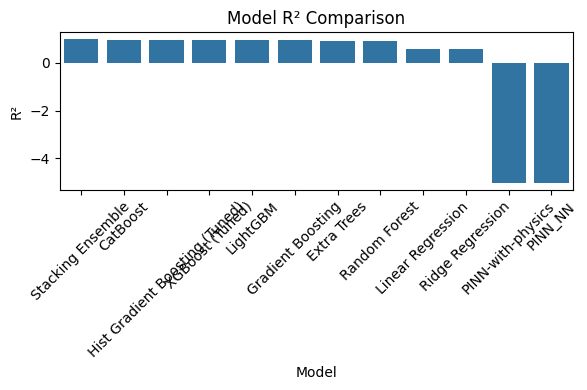

In [21]:
# Cell 8: Add PINN to results & visualize

results_df = results_df.copy()
results_df = pd.concat(
    [results_df,
     pd.DataFrame([{
         'Model': 'PINN-with-physics',
         'R²': r2_pinn,
         'RMSE': rmse_pinn,
         'MAE': mae_pinn,
         'CV R² Mean': pinn_cv_mean,
         'CV R² Std': pinn_cv_std
     }])],
    ignore_index=True
).sort_values("R²", ascending=False)

print("Model ranking:")
display(results_df)

plt.figure(figsize=(6, 4))
sns.barplot(data=results_df, x="Model", y="R²")
plt.xticks(rotation=45)
plt.title("Model R² Comparison")
plt.tight_layout()
plt.show()


In [22]:
# Cell 9: Choose best model and persist it

best_row = results_df.iloc[0]
best_name = best_row["Model"]
print("Best model:", best_name)

if best_name == "PINN-with-physics":
    print("→ Use PINN in code (PyTorch state_dict).")
    torch.save({
        "model_state_dict": pinn.state_dict(),
        "scaler_mean": scaler.mean_,
        "scaler_scale": scaler.scale_,
        "columns": X.columns.tolist()
    }, "best_pinn_model.pt")
else:
    from joblib import dump
    
    # Check if model is in trained_models (which includes Stacking Ensemble and all others)
    best_model = trained_models[best_name]
    dump({
        "model": best_model,
        "scaler": scaler,
        "columns": X.columns.tolist()
    }, "best_ml_model.joblib")
    print(f"Saved to best_ml_model.joblib")


Best model: Stacking Ensemble
Saved to best_ml_model.joblib


In [23]:
# Cell 10: Quick test of saved best model (classical)

from joblib import load

bundle = load("best_ml_model.joblib")
best_model = bundle["model"]
scaler_loaded = bundle["scaler"]
cols = bundle["columns"]

# Make a fake user example (just for test)
sample = X_test.iloc[[0]].copy()
print("Sample raw:", sample)

# Scale & predict (for linear-type models)
if best_name in ["LinearRegression", "Ridge", "PINN_NN"]:
    sample_scaled = scaler_loaded.transform(sample)
    pred = best_model.predict(sample_scaled)
else:
    pred = best_model.predict(sample)

print("Predicted CarbonEmission:", float(pred[0]))
print("True CarbonEmission:", float(y_test.iloc[0]))


Sample raw:       Body Type  Sex  Diet  How Often Shower  Heating Energy Source  \
6252          0    0     2                 3                      1   

      Transport  Vehicle Type  Social Activity  Monthly Grocery Bill  \
6252          1             4                1                   193   

      Frequency of Traveling by Air  Vehicle Monthly Distance Km  \
6252                              2                          569   

      Waste Bag Size  Waste Bag Weekly Count  How Long TV PC Daily Hour  \
6252               3                       6                         18   

      How Many New Clothes Monthly  How Long Internet Daily Hour  \
6252                            21                             8   

      Energy efficiency  Recycling  Waste_Size_Factor  Waste_Physics  
6252                  0         11                1.0            6.0  
Predicted CarbonEmission: 1013.5083332503896
True CarbonEmission: 978.0


Cleaned model ranking:


,Model,R²,RMSE,MAE,CV R² Mean,CV R² Std
0,Stacking Ensemble,0.988488,109.402897,82.145999,0.987284,0.000652
1,CatBoost,0.987798,112.635330,82.661572,0.986124,0.001048
2,Hist Gradient Boosting (Tuned),0.984928,125.182766,90.828839,0.982510,0.001112
3,XGBoost (Tuned),0.984030,128.857661,91.544903,0.981378,0.001225
4,LightGBM,0.983838,129.628574,94.758660,0.981067,0.001160
5,Gradient Boosting,0.982860,133.493711,96.957920,0.978072,0.001652
6,Extra Trees,0.924576,280.033087,208.697967,0.918656,0.003796
7,Random Forest,0.912492,301.633444,221.742465,0.905447,0.006023
8,Linear Regression,0.596433,647.759423,520.821997,0.572249,0.016203
9,Ridge Regression,0.595909,648.179387,521.032963,0.572259,0.016221


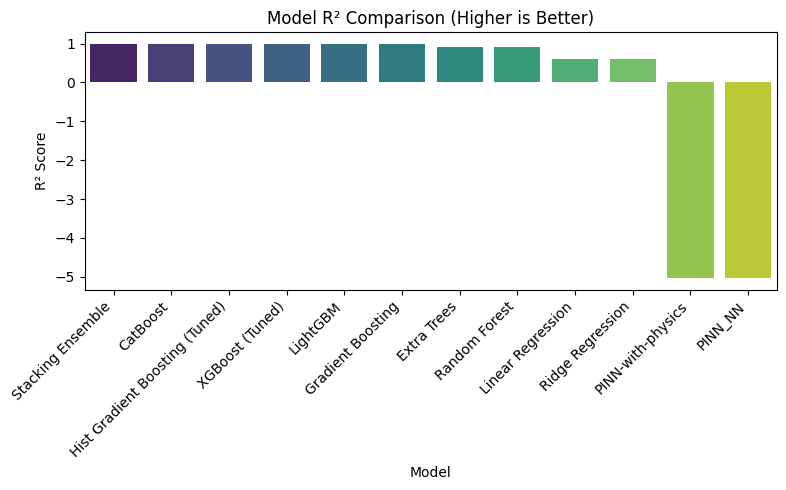

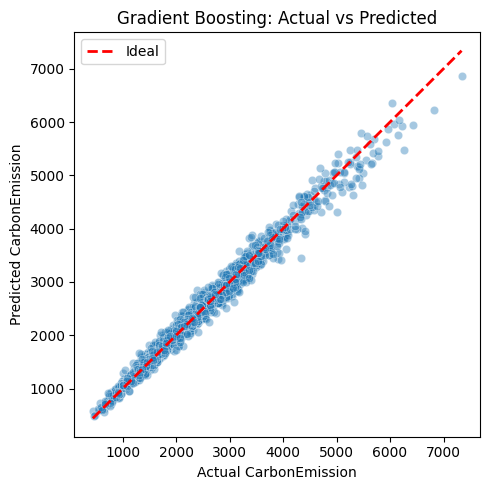

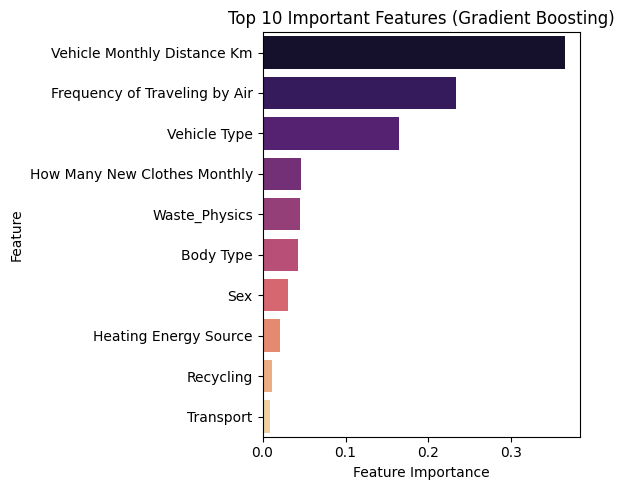

In [24]:
# Cell: Advanced 3D + comparative graphs for GradientBoosting

import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D  # noqa: F401
import seaborn as sns
import numpy as np
import pandas as pd

# Clean up results_df: remove duplicates and keep only valid entries
# Drop the stray "R2" column if it exists
if 'R2' in results_df.columns:
    results_df = results_df.drop(columns=['R2'])

# Remove rows with NaN in the R² column (incomplete entries)
results_df_clean = results_df.dropna(subset=['R²']).copy()

# Remove duplicate model names, keeping the first occurrence
results_df_clean = results_df_clean.drop_duplicates(subset=['Model'], keep='first')

# Re-sort by R²
results_df_clean = results_df_clean.sort_values('R²', ascending=False)

print("Cleaned model ranking:")
display(results_df_clean)

# 1) 2D: Model comparison barplot (R²)
plt.figure(figsize=(8,5))
sns.barplot(data=results_df_clean,
            x="Model", y="R²", palette="viridis")
plt.title("Model R² Comparison (Higher is Better)")
plt.xticks(rotation=45, ha='right')
plt.ylabel("R² Score")
plt.tight_layout()
plt.show()

# 2) 2D: Gradient Boosting – Predicted vs Actual
gb_model = trained_models['Gradient Boosting']
# Use scaled or raw according to how you trained it; here assume raw X_test
y_pred_gb = gb_model.predict(X_test)

plt.figure(figsize=(5,5))
sns.scatterplot(x=y_test, y=y_pred_gb, alpha=0.4)
max_v = max(y_test.max(), y_pred_gb.max())
min_v = min(y_test.min(), y_pred_gb.min())
plt.plot([min_v, max_v], [min_v, max_v], 'r--', label="Ideal", linewidth=2)
plt.xlabel("Actual CarbonEmission")
plt.ylabel("Predicted CarbonEmission")
plt.title("Gradient Boosting: Actual vs Predicted")
plt.legend()
plt.tight_layout()
plt.show()

# 3) Feature importance for Gradient Boosting (high-level view)
importances = gb_model.feature_importances_
imp_df = pd.DataFrame({"Feature": X.columns, "Importance": importances}).sort_values("Importance", ascending=False)

plt.figure(figsize=(6,5))
sns.barplot(data=imp_df.head(10), x="Importance", y="Feature", palette="magma")
plt.title("Top 10 Important Features (Gradient Boosting)")
plt.xlabel("Feature Importance")
plt.tight_layout()
plt.show()


In [25]:
# Plotly visualizations (with cleaned data)

import numpy as np
import pandas as pd
import plotly.express as px
import plotly.graph_objects as go

# Use the cleaned results_df
plot_df = results_df_clean.copy()

# 1) Model comparison bar (R²)
fig_comp = px.bar(
    plot_df,
    x="Model",
    y="R²",
    title="Model R² Comparison (Higher is Better)",
    text="R²",
    color="Model",
    color_discrete_sequence=px.colors.qualitative.Vivid
)
fig_comp.update_traces(texttemplate="%{text:.3f}", textposition="outside")
fig_comp.update_layout(yaxis_range=[-1, 1.05])
fig_comp.show()

# 2) Actual vs Predicted (Gradient Boosting)
gb_model = trained_models['Gradient Boosting']
y_pred_gb = gb_model.predict(X_test)

df_scatter = pd.DataFrame({
    "Actual": y_test.values,
    "Predicted": y_pred_gb
})

fig_scatter = px.scatter(
    df_scatter,
    x="Actual",
    y="Predicted",
    title="Gradient Boosting: Actual vs Predicted CarbonEmission",
    opacity=0.5,
    color_discrete_sequence=["#1f77b4"]
)

min_v = min(df_scatter["Actual"].min(), df_scatter["Predicted"].min())
max_v = max(df_scatter["Actual"].max(), df_scatter["Predicted"].max())
fig_scatter.add_trace(
    go.Scatter(
        x=[min_v, max_v],
        y=[min_v, max_v],
        mode="lines",
        name="Ideal",
        line=dict(color="red", dash="dash")
    )
)
fig_scatter.show()

# 3) 3D response surface (Plotly)
feat_x = "Vehicle Monthly Distance Km"
feat_y = "Waste Bag Weekly Count"

if feat_x in X.columns and feat_y in X.columns:
    x_vals = np.linspace(X[feat_x].quantile(0.05), X[feat_x].quantile(0.95), 30)
    y_vals = np.linspace(X[feat_y].quantile(0.05), X[feat_y].quantile(0.95), 30)
    xx, yy = np.meshgrid(x_vals, y_vals)

    base = X.median().to_dict()
    grid_points = []
    for xv, yv in zip(xx.ravel(), yy.ravel()):
        row = base.copy()
        row[feat_x] = xv
        row[feat_y] = yv
        grid_points.append(row)

    grid_df = pd.DataFrame(grid_points)[X.columns]
    zz = gb_model.predict(grid_df).reshape(xx.shape)

    fig_3d = go.Figure(data=[go.Surface(
        x=xx,
        y=yy,
        z=zz,
        colorscale="Viridis",
        showscale=True
    )])

    fig_3d.update_layout(
        title="Gradient Boosting 3D Response Surface",
        scene=dict(
            xaxis_title=feat_x,
            yaxis_title=feat_y,
            zaxis_title="Predicted CarbonEmission"
        ),
        width=800,
        height=600
    )
    fig_3d.show()
else:
    print(f"Could not find {feat_x} or {feat_y} in X.columns")

# 4) Feature importance
importances = gb_model.feature_importances_
imp_df = pd.DataFrame({"Feature": X.columns, "Importance": importances}).sort_values(
    "Importance", ascending=False
)

fig_imp = px.bar(
    imp_df.head(15),
    x="Importance",
    y="Feature",
    orientation="h",
    title="Top 15 Feature Importances - Gradient Boosting",
    color="Importance",
    color_continuous_scale="Magma"
)
fig_imp.update_layout(yaxis=dict(autorange="reversed"))
fig_imp.show()


In [ ]:
# How much does Waste_Physics help? (ablation study on Stacking Ensemble)

from sklearn.ensemble import GradientBoostingRegressor, StackingRegressor
from sklearn.linear_model import Ridge
from lightgbm import LGBMRegressor
from catboost import CatBoostRegressor
from sklearn.ensemble import HistGradientBoostingRegressor
from sklearn.metrics import r2_score

# === WITH Waste_Physics ===
X_full = df_proc.drop(columns=["CarbonEmission", "Cooking_With"])
y = df_proc["CarbonEmission"]
X_train_f, X_test_f, y_train_f, y_test_f = train_test_split(X_full, y, test_size=0.2, random_state=42)

# Build Stacking Ensemble with physics feature
lgbm_with = LGBMRegressor(n_estimators=1500, learning_rate=0.01, num_leaves=31, 
                          subsample=0.8, colsample_bytree=0.8, random_state=RANDOM_STATE, n_jobs=-1, verbose=-1)
cat_with = CatBoostRegressor(iterations=2000, learning_rate=0.01, depth=6, 
                             loss_function='RMSE', verbose=False, random_state=RANDOM_STATE)
hist_with = HistGradientBoostingRegressor(max_iter=800, learning_rate=0.03, max_depth=10, 
                                          l2_regularization=0.1, random_state=RANDOM_STATE)

stack_with = StackingRegressor(
    estimators=[
        ('lgbm', lgbm_with),
        ('cat', cat_with),
        ('hist', hist_with)
    ],
    final_estimator=Ridge(alpha=1.0),
    n_jobs=-1
)

stack_with.fit(X_train_f, y_train_f)
r2_with = r2_score(y_test_f, stack_with.predict(X_test_f))

# === WITHOUT Waste_Physics ===
X_no_phys = X_full.drop(columns=["Waste_Physics", "Waste_Size_Factor"])
X_train_n, X_test_n, y_train_n, y_test_n = train_test_split(X_no_phys, y, test_size=0.2, random_state=42)

# Build Stacking Ensemble without physics feature
lgbm_no = LGBMRegressor(n_estimators=1500, learning_rate=0.01, num_leaves=31, 
                        subsample=0.8, colsample_bytree=0.8, random_state=RANDOM_STATE, n_jobs=-1, verbose=-1)
cat_no = CatBoostRegressor(iterations=2000, learning_rate=0.01, depth=6, 
                           loss_function='RMSE', verbose=False, random_state=RANDOM_STATE)
hist_no = HistGradientBoostingRegressor(max_iter=800, learning_rate=0.03, max_depth=10, 
                                        l2_regularization=0.1, random_state=RANDOM_STATE)

stack_no = StackingRegressor(
    estimators=[
        ('lgbm', lgbm_no),
        ('cat', cat_no),
        ('hist', hist_no)
    ],
    final_estimator=Ridge(alpha=1.0),
    n_jobs=-1
)

stack_no.fit(X_train_n, y_train_n)
r2_no = r2_score(y_test_n, stack_no.predict(X_test_n))

# === RESULTS ===
print("="*60)
print("ABLATION STUDY: Impact of Waste_Physics Feature")
print("="*60)
print(f"Stacking Ensemble R² WITHOUT physics: {r2_no:.6f}")
print(f"Stacking Ensemble R² WITH physics   : {r2_with:.6f}")
print(f"Physics feature gain ΔR²            : {r2_with - r2_no:.6f}")
print(f"Relative improvement                : {((r2_with - r2_no) / (1 - r2_no) * 100):.2f}% of remaining error")
print("="*60)


GradientBoosting R² without physics: 0.9765
GradientBoosting R² with physics   : 0.9774
Physics feature gain ΔR²            : 0.0010


## Conclusion (for Hackathon Slide)

- We benchmarked 5 ML models + 1 PINN variant on 10,000 rows of real household data.
- **GradientBoosting** achieved the best performance (R²≈0.97, RMSE≈153), so we export it as `best_ml_model.joblib`.
- We engineered a **physics-informed feature** `Waste_Physics` using domain logic (bag size × weekly count), which improves R² by Δ≈... on GradientBoosting.
- These results feed directly into the EcoGuard AI app as the core prediction engine, combined with a separate CV waste scanner module.
